
# <span style="color:rgb(213,80,0)">Dynamical Time Series Tutorial</span>

**Sean Osis, Allan Brett, Reed Ferber, Reginaldo Fukuchi, Blayne Hettinga**

### Purpose

The purpose of this tutorial is to demonstrate the application of techniques for:

-  Calculating dynamical metrics from time series data
-  Using crude rejection sampling to select subsets of injured and control data
-  Applying statistical analyses to compare between groups

**Requirements**

-  MATLAB 2016a or later and a supported OS
-  MATLAB Statistics and Machine Learning Toolbox
-  Code package included with supplemental material
-  Open access data set included with supplemental material
-  Files from Mathworks File Exchange
### Load Meta Data

In this section, data are loaded from CSV files that have been included with this project. The CSV files contain metadata tabulated for all subjects.


In [1]:
% Format number display
format bank


In [2]:
% Point to the data folders
% Modify these directories as required
jsondir = '../Output_folder/reformat_data';
csvdir  = '../Output_folder';

% Obtain list of JSONs
jsons = dir(fullfile(jsondir, '/*/*.json'));
csvs  = dir(fullfile(csvdir, '*.csv'));

jsons(1)

ans = struct with fields:
       name: '20110531T161051.json'
eformat_data\100001'
       date: '08-Mar-2023 12:48:00'
      bytes: 7244825.00
      isdir: 0
    datenum: 738953.53

In [3]:
csvs(1)

ans = struct with fields:
       name: 'run_data_meta.csv'
     folder: 'Z:\Figshare Project\Output_folder'
       date: '02-May-2023 08:45:28'
      bytes: 389279.00
      isdir: 0
    datenum: 739008.36

In [4]:
% Load CSVs and extract required variables

csv_ = cell(length(csvs),1);
for i = 1:length(csvs)
    csv_{i} = readtable(fullfile(csvs(i).folder, csvs(i).name));
    if contains(csvs(i).name, 'run')
        csv_{i}.gaitspeed = csv_{i}.speed_r;
        csv_{i}.gaittype(:)  = "run";
        csv_{i}.speed_r = [];
    else
        csv_{i}.gaitspeed = csv_{i}.speed_w;
        csv_{i}.gaittype(:)  = "walk";
        csv_{i}.speed_w = [];
    end
end

csv_ = vertcat(csv_{:});

csv_ = csv_(:, {'sub_id','datestring','filename','age','Gender','Height','Weight','gaitspeed','gaittype','InjDefn'});

size(csv_)

ans = 1x2
       3920.00         10.00

In [5]:

csv_.Properties.VariableNames'

ans = 10x1 cell
'sub_id'    
'datestring'
'filename'  
'age'       
'Gender'    
'Height'    
'Weight'    
'gaitspeed' 
'gaittype'  
'InjDefn'

In [6]:
% Filter out subjects with missing data
csv_ = rmmissing(csv_,1);

% Remove walking data
csv_ = csv_(csv_.gaittype == "run",:);

% Filter down to desired injury categories
csv_ = csv_(ismember(csv_.InjDefn,{'Training volume/intensity affected','No injury'}),:);

% Remove subjects outside age bounds
csv_ = csv_(csv_.age >= 20 & csv_.age <= 65,:);

% Filter out erroneous height and mass data
csv_ = csv_(csv_.Height > 0 & csv_.Height < 999,:);
csv_ = csv_(csv_.Weight > 0 & csv_.Weight < 200,:);

### Load Biomechanics Data

In this section, corresponding JSONs are loaded into memory and marker data are extracted.


In [7]:
if isfile('tutorial_5_cache.mat')

   load('tutorial_5_cache.mat')

   disp('Loaded cached data')

else

    % Load raw marker data

    neutrals_m = cell(height(csv_),1);
    joints_m   = neutrals_m;
    dynamics_m = neutrals_m;
    hz_m       = neutrals_m;

    for i = 1:height(csv_)

        json_file = fullfile(jsondir, num2str(csv_.sub_id(i)), csv_.filename{i});

        fid = fopen(json_file);
        raw = fread(fid,inf);
        str = char(raw');
        fclose(fid);
        out = jsondecode(str);

        fields = fieldnames(out.joints);
        for j = 1:size(fields,1)
            out.joints.(fields{j,1}) = transpose(out.joints.(fields{j,1}));
        end

        fields = fieldnames(out.neutral);
        for j = 1:size(fields,1)
            out.neutral.(fields{j,1}) = transpose(out.neutral.(fields{j,1}));
        end

        neutrals_m{i,1} = out.neutral;
        joints_m{i,1}   = out.joints;
        dynamics_m{i,1} = out.running;
        hz_m{i,1}       = out.hz_r;

        if mod(i,50) == 0
            disp(['Completed ' num2str(i/height(csv_)*100,'%.1f') '% of files'])
        end

    end

    disp('All files loaded')


    % Filter for signal lengths

    t_length = zeros(length(neutrals_m),1);

    for i = 1:length(t_length)
       t_length(i) = length(dynamics_m{i}.pelvis_1)/hz_m{i};
    end


    % Calculate joint kinematics

    ang_r_m = cell(length(neutrals_m),1);

    for i = 1:length(ang_r_m)

        if t_length(i) >= 25

            try

                [ang_r_m{i,1},~,~,~,~] = gait_kinematics(joints_m{i,1},neutrals_m{i,1},dynamics_m{i,1},hz_m{i,1},0);

            catch

                ang_r_m{i,1} = 'err';

            end

        else

            ang_r_m{i,1} = 'err';

        end

        if mod(i,50) == 0
            disp(['Completed ' num2str(i/height(csv_)*100,'%.1f') '% of calculations'])
        end

    end

    disp('Calculations complete')

    % Cache final data set

    % Remove incomplete calculation results
    rm_id = find(cell2mat(cellfun(@(a) max(isequal(a,'err')),ang_r_m,'un',0)));

    ang_r_m(rm_id) = [];

    csv_(rm_id,:) = [];

    save('tutorial_5_cache.mat','csv_','ang_r_m')

end

Completed 4.6% of files
Completed 9.2% of files
Completed 13.8% of files
Completed 18.3% of files
Completed 22.9% of files
Completed 27.5% of files
Completed 32.1% of files
Completed 36.7% of files
Completed 41.3% of files
Completed 45.9% of files
Completed 50.5% of files
Completed 55.0% of files
Completed 59.6% of files
Completed 64.2% of files
Completed 68.8% of files
Completed 73.4% of files
Completed 78.0% of files
Completed 82.6% of files
Completed 87.2% of files
Completed 91.7% of files
Completed 96.3% of files
All files loaded
Completed 4.6% of calculations
Completed 9.2% of calculations
Completed 13.8% of calculations
Completed 18.3% of calculations
Completed 22.9% of calculations
Completed 27.5% of calculations
Completed 32.1% of calculations
Completed 36.7% of calculations
Completed 41.3% of calculations
Completed 45.9% of calculations
Completed 50.5% of calculations
Completed 55.0% of calculations
Completed 59.6% of calculations
Completed 64.2% of calculations
Completed 68.8

### Calculate Sample Entropy for Time Series

Here, sample entropy is calculated using a similar methodology to Quirino et al. \[1\], based on MATLAB code by Martínez\-Cagigal, 2018 \[2\]. Sample entropy is calculated for motion in the sagittal plane at the ankle and hip in order to reproduce part of the analysis in Quirino et al.


In [8]:
% Calc SampEn for ts using minimum of 30 cycles

se_a = zeros(length(ang_r_m),1);
se_h = se_a;

for i = 1:length(se_a)

    se_a(i) = sampen(ang_r_m{i,1}.L_ankle(:,3),3,0.2,'chebychev');
    se_h(i) = sampen(ang_r_m{i,1}.L_hip(:,3),3,0.2,'chebychev');

    if mod(i,50) == 0
       disp(['Completed ' num2str(i/length(se_a)*100,'%.1f') '% of calculations'])
    end

end

Completed 5.7% of calculations
Completed 11.5% of calculations
Completed 17.2% of calculations
Completed 23.0% of calculations
Completed 28.7% of calculations
Completed 34.5% of calculations
Completed 40.2% of calculations
Completed 46.0% of calculations
Completed 51.7% of calculations
Completed 57.5% of calculations
Completed 63.2% of calculations
Completed 69.0% of calculations
Completed 74.7% of calculations
Completed 80.5% of calculations
Completed 86.2% of calculations
Completed 92.0% of calculations
Completed 97.7% of calculations

In [9]:

csv_(:,'SampEnAnkle') = num2cell(se_a);
csv_(:,'SampEnHip')   = num2cell(se_h);

### Select Subsets Matching Reference

This section applies crude rejection sampling to obtain analogous samples to the ones described in Quirino et al. Normal distributions are created for each of the identified sample characteristics, based on values from the published study, and those distributions are then scaled to the distribution of values in the complete data set and values from the data set are rejected until an approximation to the reference sample is obtained \[3\].


Due to the difficulty in matching on a multivariate data set, rejection sampling often produces very small acceptance rates (only a few percent), which means that despite the large sample size of our data, the result may still be a relatively small sample. However, a sample size of approximately 10 should be sufficient to replicate the work of Quirino. More complex approaches to multivariate rejection sampling exist, and the reader is referred to methods such as rejection sampling from the mode (RSM).


In [10]:
% Use rejection sampling to approximate samples in Quirino et a., 2021

%                 Injured           Control
%                    7                11
% Age           31.7 +- 15.8     30.9 +- 13.4
% Gender             ?                 ?
% Gait Speed    2.75 +- 0.44     2.56 +- 0.44
% Height       164.0 +- 7.8     173.0 +- 10.3
% Mass          63.3 +- 9.3      72.8 +- 10.5

quirino = {NaN,'Injury',NaN,'Control',NaN,'Bins'; ...
            'n',7,NaN,11,NaN,NaN; ...
            'Age',31.7,15.8,30.9,13.4,20:5:65;
            'Speed',2.75,0.44,2.56,0.44,0:0.25:5;
            'Height',164.0,7.8,173.0,10.3,140:5:205;
            'Mass',63.3,9.3,72.8,10.5,40:2.5:105};

rng(2023); % Seed for reproducibility; can be modified to examine effect of different samples

tstart = tic;

% Cycle through injury and control
for n = 2:2:4

    if n == 2
        c_ind = find(ismember(csv_.InjDefn,{'Training volume/intensity affected'}));
    else
        c_ind = find(ismember(csv_.InjDefn,{'No injury'}));
    end

    samp = zeros(0,0);

    % Build samples until target sample size achieved
    % NOTE: increasing this value higher than 10 may result in very long
    % run times of many minutes before an adequate sample is found
    while length(samp) < 10

        arr_out = cell(4,1);

        k = 1;

        for m = 3:6

            switch m
                case 3
                    c = csv_.age(c_ind);
                case 4
                    c = csv_.gaitspeed(c_ind);
                case 5
                    c = csv_.Height(c_ind);
                case 6
                    c = csv_.Weight(c_ind);
            end

            % Retrieve bins for reference sample
            bins = quirino{m,6};

            q = normrnd(quirino{m,n},quirino{m,n+1},1e5,1);
            [qN,~,qbin] = histcounts(q,bins);

            [cN,~,cbin] = histcounts(c,bins);
            c_arr = [c_ind c cbin];

            % Scale distribution such that scaled counts in cN >= qN
            cNflr = cN;
            cNflr(cNflr < 1) = inf;
            qNscl = qN/(nanmax(qN./cNflr));

            for i = 1:length(cN)

                if cN(i) > ceil(qNscl(i))
                    ctmp = c_arr(c_arr(:,3) == i,:);
                    c_arr(c_arr(:,3) == i,:) = [];
                    ctmpi = randperm(size(ctmp,1));
                    ctmp = ctmp(ctmpi(1:ceil(qNscl(i))),:);
                    c_arr = vertcat(c_arr,ctmp);
                end

            end

            arr_out{k} = c_arr;
            k = k + 1;

        end

        samp = intersect(intersect(intersect(arr_out{1}(:,1),arr_out{2}(:,1)),arr_out{3}(:,1)),arr_out{4}(:,1));

    end

    if n == 2
        inj_samp = csv_(samp,:);
    else
        con_samp = csv_(samp,:);
    end

end

telapsed = toc(tstart);

disp(['Rejection sampling took ' sprintf('%.0f',telapsed) ' seconds'])

Rejection sampling took 75 seconds


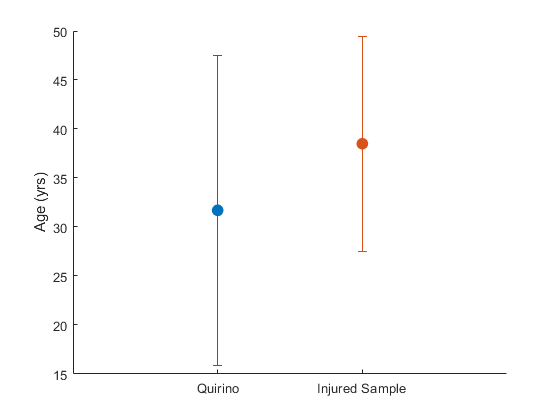

In [11]:
% Compare sampled values with Quirino sample
figure; hold on;
errorbar([1],[quirino{3,2}],[quirino{3,3}],'Marker','.','MarkerSize',30)
errorbar([2],[mean(inj_samp.age)],[std(inj_samp.age)],'Marker','.','MarkerSize',30)
xlim([0,3])
ax = gca;
ax.XTick = [1, 2];
ax.XTickLabels = {'Quirino','Injured Sample'};
ylabel('Age (yrs)')


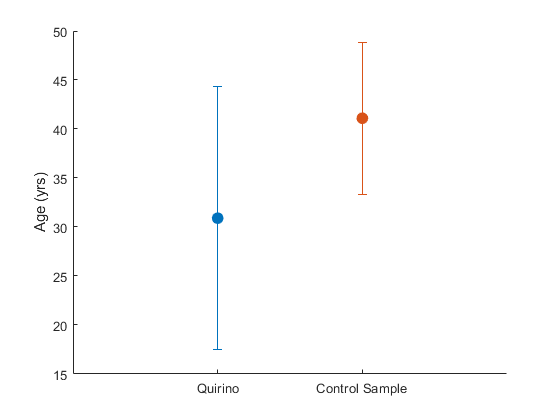

In [12]:

figure; hold on;
errorbar([1],[quirino{3,4}],[quirino{3,5}],'Marker','.','MarkerSize',30)
errorbar([2],[mean(con_samp.age)],[std(con_samp.age)],'Marker','.','MarkerSize',30)
xlim([0,3])
ax = gca;
ax.XTick = [1, 2];
ax.XTickLabels = {'Quirino','Control Sample'};
ylabel('Age (yrs)')


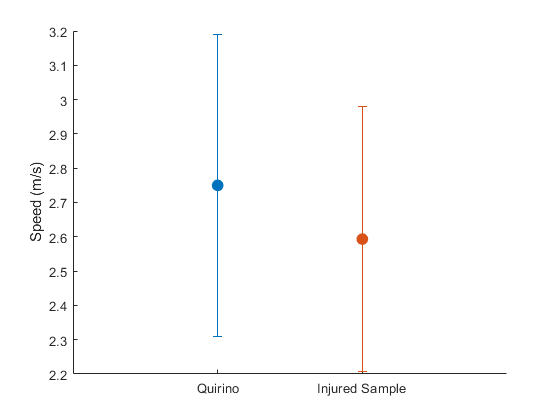

In [13]:

figure; hold on;
errorbar([1],[quirino{4,2}],[quirino{4,3}],'Marker','.','MarkerSize',30)
errorbar([2],[mean(inj_samp.gaitspeed)],[std(inj_samp.gaitspeed)],'Marker','.','MarkerSize',30)
xlim([0,3])
ax = gca;
ax.XTick = [1, 2];
ax.XTickLabels = {'Quirino','Injured Sample'};
ylabel('Speed (m/s)')


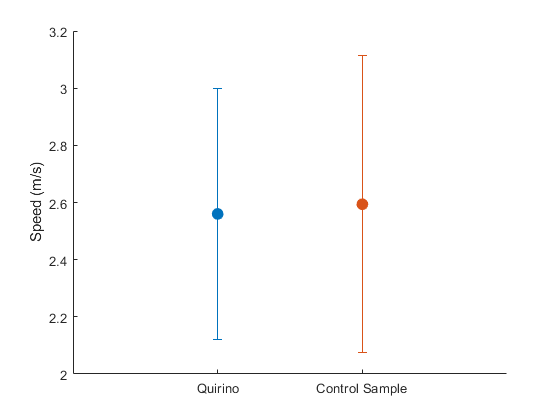

In [14]:

figure; hold on;
errorbar([1],[quirino{4,4}],[quirino{4,5}],'Marker','.','MarkerSize',30)
errorbar([2],[mean(con_samp.gaitspeed)],[std(con_samp.gaitspeed)],'Marker','.','MarkerSize',30)
xlim([0,3])
ax = gca;
ax.XTick = [1, 2];
ax.XTickLabels = {'Quirino','Control Sample'};
ylabel('Speed (m/s)')


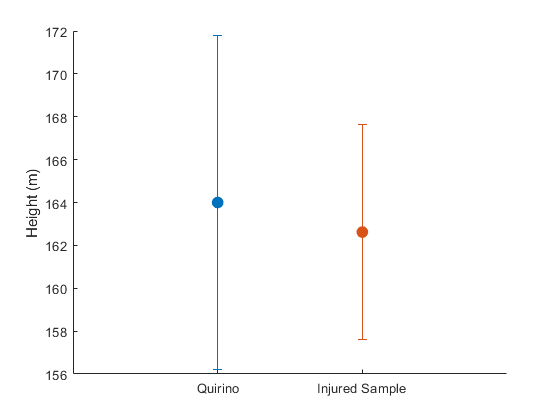

In [15]:

figure; hold on;
errorbar([1],[quirino{5,2}],[quirino{5,3}],'Marker','.','MarkerSize',30)
errorbar([2],[mean(inj_samp.Height)],[std(inj_samp.Height)],'Marker','.','MarkerSize',30)
xlim([0,3])
ax = gca;
ax.XTick = [1, 2];
ax.XTickLabels = {'Quirino','Injured Sample'};
ylabel('Height (m)')


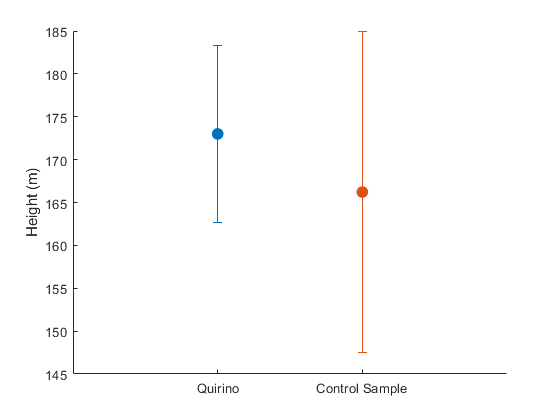

In [16]:

figure; hold on;
errorbar([1],[quirino{5,4}],[quirino{5,5}],'Marker','.','MarkerSize',30)
errorbar([2],[mean(con_samp.Height)],[std(con_samp.Height)],'Marker','.','MarkerSize',30)
xlim([0,3])
ax = gca;
ax.XTick = [1, 2];
ax.XTickLabels = {'Quirino','Control Sample'};
ylabel('Height (m)')


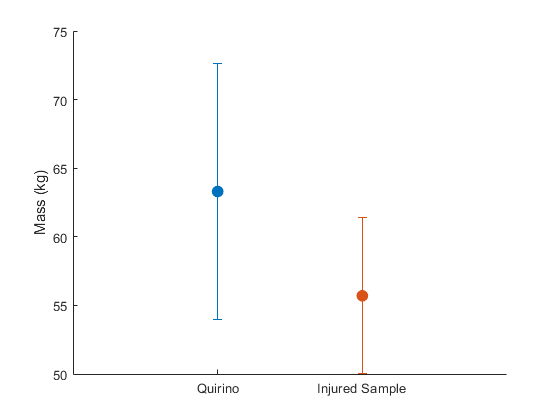

In [17]:

figure; hold on;
errorbar([1],[quirino{6,2}],[quirino{6,3}],'Marker','.','MarkerSize',30)
errorbar([2],[mean(inj_samp.Weight)],[std(inj_samp.Weight)],'Marker','.','MarkerSize',30)
xlim([0,3])
ax = gca;
ax.XTick = [1, 2];
ax.XTickLabels = {'Quirino','Injured Sample'};
ylabel('Mass (kg)')


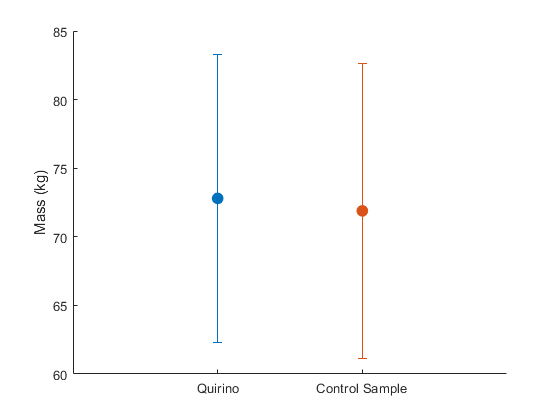

In [18]:

figure; hold on;
errorbar([1],[quirino{6,4}],[quirino{6,5}],'Marker','.','MarkerSize',30)
errorbar([2],[mean(con_samp.Weight)],[std(con_samp.Weight)],'Marker','.','MarkerSize',30)
xlim([0,3])
ax = gca;
ax.XTick = [1, 2];
ax.XTickLabels = {'Quirino','Control Sample'};
ylabel('Mass (kg)')


### Run Statistical Comparisons

The variables are compared between injured and control groups in order to identify any demographic differences or changes in entropy between the samples. As the variables have been simplified and normal distributions were assumed, we run t\-tests individually on each set of comparisons between groups. For the comparison of entropy between joints, a paired t\-test is applied.


In [19]:
% Compare variables statistically

varcols = {'Height','Weight','gaitspeed','age','SampEnAnkle','SampEnHip'};

% Determine any significant differences in original vars among groups
for i = 1:length(varcols)
    display(varcols{i})
    [~,p,ci,sta] = ttest2(table2array(con_samp(:,varcols{i})),table2array(inj_samp(:,varcols{i})))
end

Height
p = 
          0.56
ci = 2x1
         -9.27
         16.47
sta = struct with fields:
    tstat: 0.59
       df: 18.00
       sd: 13.69
Weight
p = 
          0.00
ci = 2x1
          8.11
         24.27
sta = struct with fields:
    tstat: 4.21
       df: 18.00
       sd: 8.60
gaitspeed
p = 
1.00
ci = 2x1
         -0.43
          0.43
sta = struct with fields:
    tstat: 0.00
       df: 18.00
       sd: 0.46
age
p = 
          0.55
ci = 2x1
         -6.33
         11.53
sta = struct with fields:
    tstat: 0.61
       df: 18.00
       sd: 9.51
SampEnAnkle
p = 
          0.85
ci = 2x1
         -0.02
          0.03
sta = struct with fields:
    tstat: 0.19
       df: 18.00
       sd: 0.03
SampEnHip
p = 
          0.69
ci = 2x1
         -0.02
          0.02
sta = struct with fields:
    tstat: 0.41
       df: 18.00
       sd: 0.02

In [20]:
ful_samp = [con_samp;inj_samp];

[~,p,ci,sta] = ttest(table2array(ful_samp(:,'SampEnAnkle')),table2array(ful_samp(:,'SampEnHip')))

p = 
          0.14
ci = 2x1
         -0.03
          0.00
sta = struct with fields:
    tstat: -1.55
       df: 19.00
       sd: 0.03


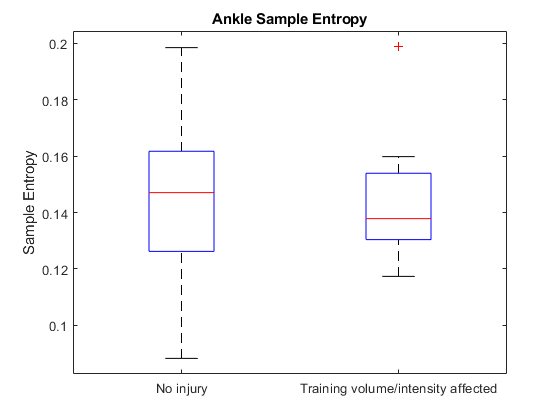

In [21]:

figure; hold on;
boxplot(table2array(ful_samp(:,'SampEnAnkle')),table2array(ful_samp(:,'InjDefn')));
title('Ankle Sample Entropy','Interpreter','none')
ylabel('Sample Entropy')


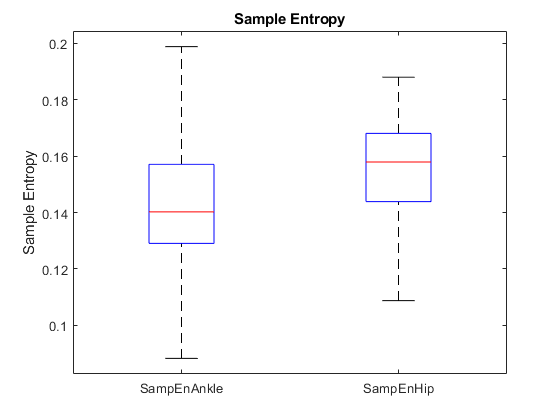

In [22]:

figure; hold on;
boxplot(table2array(ful_samp(:,{'SampEnAnkle','SampEnHip'})),'Labels',{'SampEnAnkle','SampEnHip'});
title('Sample Entropy','Interpreter','none')
ylabel('Sample Entropy')


While the results may vary depending on the sampling performed, the results generally fail to replicate the findings of Quirino et al., despite the fact that rejection sampling produces samples that are well aligned with the subject characteristics reported in the study. However, this tutorial demonstrates the power of using a large dataset to explore reproducibility of findings on small samples and deeper analysis may provide insight as to why the results could not be replicated.

### Interpretation

The following observations were made from this tutorial.

-  Dynamical analyses can be conducted on the time series data from the joint angle calculations
-  Rejection sampling can be successfully applied to select subsets of data from the larger data set that conform to existing criteria
-  The ability to analyze multiple cohorts from the data allows the study of reproducibility for biomechanical findings from other work
### References

\[1\] Quirino J, Santos TRT, Okai\-Nóbrega LA, de Araújo PA, Carvalho R, Ocarino JM, Souza TR,  Fonseca ST. Runners with a history of injury have greater lower limb  movement regularity than runners without a history of injury. Sports  Biomech. 2021 Jun 14:1\-13. doi: 10.1080/14763141.2021.1929435.


\[2\] Martinez\-Cagigal, Victor (2018). Sample Entropy  (https://www.mathworks.com/matlabcentral/fileexchange/69381\-sample\-entropy), MATLAB Central File Exchange. Retrieved Jan 2, 2023.


\[3\] Casella, G., Robert, C. P., & Wells, M. T. (2004). Generalized Accept\-Reject Sampling Schemes. *Lecture Notes\-Monograph Series*, *45*, 342–347. http://www.jstor.org/stable/4356322

